# skimage.filters.threshold_otsu
Determina un valor de umbral óptimo para binarizar la imagen, separando el fondo de los objetos.

In [24]:
import cv2
import open3d as o3d
from skimage import filters
import matplotlib.pyplot as plt
from transformers import pipeline
import numpy as np 

Path de la imagen

In [25]:
orignal_path = "./../Data/bottle_center.png"

Se carga el modelo para extraer el mapa de profundidad

In [26]:
depth_estimation_pipeline = pipeline("depth-estimation", model="vinvino02/glpn-nyu", force_download=True)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [27]:
temp = depth_estimation_pipeline(orignal_path)
depth_map_tensor = temp['predicted_depth']
dm = depth_map_tensor[0].numpy()

#make it uint8
max_pixel_value = dm.max()
dm = dm / max_pixel_value * 255
dm = dm.astype('uint8')

Text(0.5, 1.0, 'Filtered Image')

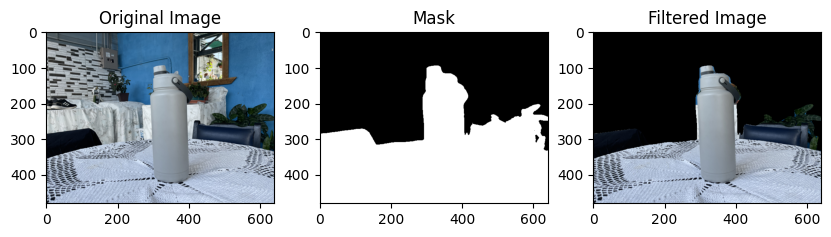

In [28]:
ori_image = cv2.imread(orignal_path, cv2.IMREAD_COLOR)
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
gray_image = cv2.cvtColor(ori_image, cv2.COLOR_RGB2GRAY)

threshold = filters.threshold_otsu(dm)
mask = dm < threshold # Segmentar según el threshold
mask_3ch = np.stack([mask]*3, axis=-1) # Convertir la máscara a 3 canales
fil_image = ori_image * mask_3ch


fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(ori_image)
axs[0].set_title('Original Image')

axs[1].imshow(mask, cmap='gray')
axs[1].set_title('Mask')

axs[2].imshow(fil_image, cmap='gray')
axs[2].set_title('Filtered Image')

In [29]:
print(dm)

[[234 225 219 ... 196 200 214]
 [215 194 177 ... 137 143 164]
 [230 220 208 ... 153 159 163]
 ...
 [ 43  45  44 ...  41  41  40]
 [ 45  41  44 ...  40  45  38]
 [ 51  48  43 ...  40  41  42]]


In [30]:
def generate_pcd(dm):
    # FX_DEPTH = 1
    # FY_DEPTH = 1
    # CX_DEPTH = 0
    # CY_DEPTH = 0
    FX_DEPTH = 5.8262448167737955e+02
    FY_DEPTH = 5.8269103270988637e+02
    CX_DEPTH = 3.1304475870804731e+02
    CY_DEPTH = 2.3844389626620386e+02


    height, width = dm.shape

    points = []
    for i in range(height):
        for j in range(width):
            if dm[i, j] == 0:
                continue
            z = dm[i, j] * 500
            x = (j - CX_DEPTH) * z/ FX_DEPTH
            y = (i - CY_DEPTH) * z/ FY_DEPTH
            points.append([x, y, z])
    points = np.array(points)
    return points



In [31]:
points = generate_pcd(dm*mask)
pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(points)
colors = ori_image[mask]/255
pcd1.colors = o3d.utility.Vector3dVector(colors)


In [32]:
points = generate_pcd(dm)
pcd2 = o3d.geometry.PointCloud()
pcd2.points = o3d.utility.Vector3dVector(points)
colors = ori_image.reshape(ori_image.shape[0]*ori_image.shape[1], 3)/255
pcd2.colors = o3d.utility.Vector3dVector(colors)


In [33]:
# o3d.visualization.draw_geometries([pcd1])

Text(0.5, 0.92, 'Original Point Cloud')

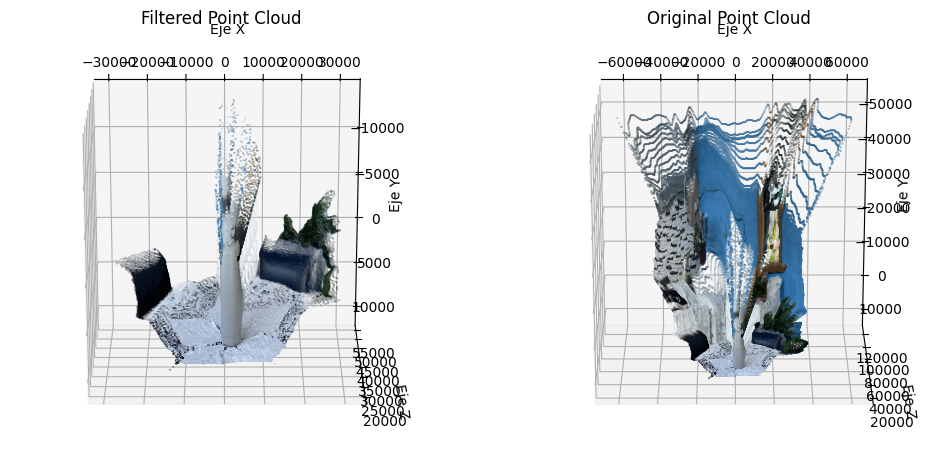

In [34]:
from mpl_toolkits.mplot3d import Axes3D


fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(12, 6))


pcd = np.asarray(pcd1.points)
x, y , z = pcd[:, 0], pcd[:, 1], pcd[:, 2]
colors = np.asarray(pcd1.colors)

# Graficar la nube de puntos
ax1.scatter(x, y, z, c=colors, s=0.1)
ax1.view_init(elev=-70, azim=-90) #elevacion y rotacion
# Configurar etiquetas
ax1.set_xlabel('Eje X')
ax1.set_ylabel('Eje Y')
ax1.set_zlabel('Eje Z')
ax1.set_title('Filtered Point Cloud')

pcd = np.asarray(pcd2.points)
x, y , z = pcd[:, 0], pcd[:, 1], pcd[:, 2]
colors = np.asarray(pcd2.colors)

ax2.scatter(x, y, z, c=colors, s=0.1)
ax2.view_init(elev=-70, azim=-90) #elevacion y rotacion
# Configurar etiquetas
ax2.set_xlabel('Eje X')
ax2.set_ylabel('Eje Y')
ax2.set_zlabel('Eje Z')
ax2.set_title('Original Point Cloud')